# BERT Clustering

Unsupervised clustering of forum posts using the text body. A simple approach to try and find similar posts without strict classification.

Most of the process and code were taken from [Maarten Grootendorst](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6).

Right now the model doesn't do anything, which is very sad.

References

1. [Topic Modeling with BERT](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)
2. [Multi-label Text Classification using BERT - The Mighty Transformer](https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d)
3. [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning)

In [1]:
!pip install transformers -q
!pip install sentence_transformers -q
!pip install umap-learn -q
!pip install hdbscan -q

import re
import umap
import torch
import hdbscan
import numpy as np
import pandas as pd
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [2]:
np.random.RandomState(123)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'using {torch.cuda.get_device_name(0)}')
else:
    print('no GPU avaiable')

using Tesla T4


## Load Data

In [3]:
df_ori = pd.read_json('https://github.com/charlotte-zhuang/forum-recommender/blob/master/data/sitepoint.json?raw=true')
df_ori.head()

,title,category,tags,post
0,Wordpress Website speed is too slow?,CMS & WordPress,[wordpress],"[Hi,, \nI am a beginner…I’ve created an affili..."
1,Turn variable into literal string?,JavaScript,[],"[Hello ,, \nI’m having a prob putting dialog.s..."
2,PDF and SEO for any URL quotation,Social Media,[],[I need help if any quotation of URL without l...
3,How to change the lighting of an image in CSS,HTML & CSS,[],[How do I change the lighting of an image usin...
4,Computer humour,Community,[],[Gotta love a good laugh after a long day. ]


## Preprocessing

In [4]:
def clean_post(text_l: list) -> str:
    '''Converts a list of text into a single string that
        can be tokenized.
    '''
    
    text = ' '.join(text_l)
    
    # remove links
    text = re.sub(r'https?:\/\/[^\s]*', r'', text)
    
    # remove dots that aren't periods
    text = re.sub(r'\.([^\s])', r'\1', text)
    
    # remove closed single quotes
    text = re.sub(r"‘([^‘’]*)’", r'\1', text)

    # remove unwanted characters
    text = re.sub(r"[^\w\s\d\.?!’]+", r' ', text)
    
    # remove repeated special characters
    text = re.sub(r"([’\.?!])[’\.?!]+", r'\1', text)
    
    # remove extra spaces
    text = re.sub(r'\s{2,}', r' ', text)
    
    return text

In [5]:
df = df_ori.drop(labels=['title', 'tags'], axis=1)
df['post'] = df['post'].apply(clean_post)

for i in range(5):
    print(df.iat[i, 1], end='\n\n')

Hi I am a beginner I’ve created an affiliate website before 5 months ago with the help of Wordpress. But the website speed is slow. I’ve tried alot to improve website speed but still the website speed is not aimproving. I installed Wp Rocket Premium Plugin and also Smush plugin for Image compression but no the speed for desktop is 80 and for Mobile it is only 60 Can any one from support team guide me how I can improve my website speed? Thanks 

Hello I’m having a prob putting dialogshowOpenDialog result into fsreadFileSync FilePathstoString toString . Ie from variable FilePaths into fsreadFileSync because fs. requires a string . I am getting error TypeError Cannot read property toString of undefined The following doesn’t work fsreadFileSync FilePathstoString toString Thanks for your Help 

I need help if any quotation of URL without link is also a benefit for SEO and social media if this is included inside PDF.

How do I change the lighting of an image using CSS?

Gotta love a good lau

In [6]:
# optionally drop data for convenience
# df = df[:1000]

## Embedding

Using DistilBERT from Sentence Transformers

In [7]:
st_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = st_model.encode(df['post'], show_progress_bar=True)

## Clustering

Reduce dimensionality

In [8]:
umap_model = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

umap_embeddings.shape

(3000, 5)

Cosine similarity clustering

In [9]:
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')
hdbscan_model.fit(umap_embeddings)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=15, min_samples=None, p=None,
        prediction_data=False)

## Visualization

In [15]:
umap_2d = umap.UMAP(
    n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')
umap_data_2d = umap_2d.fit_transform(embeddings)

df_res = pd.DataFrame(umap_data_2d, columns=['x', 'y'])
df_res['labels'] = hdbscan_model.labels_

Plot clusters

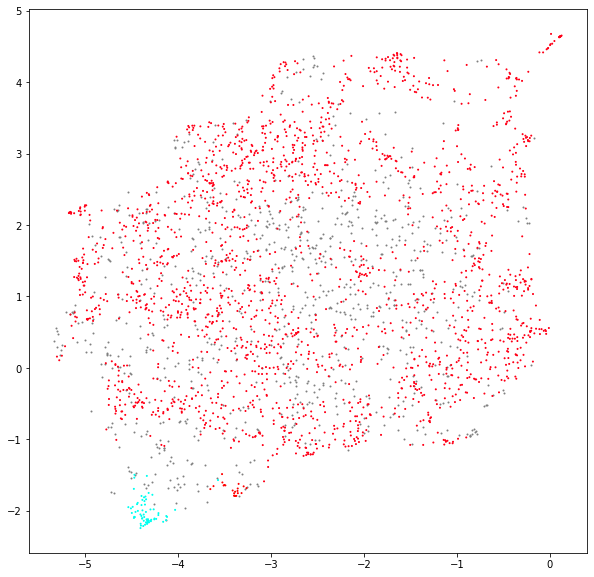

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
outliers = df_res.loc[df_res.labels == -1, :]
clustered = df_res.loc[df_res.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color='gray', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')

plt.show()

In [19]:
df['pred_label'] = hdbscan_model.labels_

df_label_0 = df[df['pred_label'] == 0]
for i in range(3):
  print(df_label_0.iat[i, 1], '\nLabel:', df_label_0.iat[i, 2], end='\n\n')

df_label_1 = df[df['pred_label'] == 1]
for i in range(3):
  print(df_label_1.iat[i, 1], '\nLabel:', df_label_1.iat[i, 2], end='\n\n')

Hi I am a beginner I’ve created an affiliate website before 5 months ago with the help of Wordpress. But the website speed is slow. I’ve tried alot to improve website speed but still the website speed is not aimproving. I installed Wp Rocket Premium Plugin and also Smush plugin for Image compression but no the speed for desktop is 80 and for Mobile it is only 60 Can any one from support team guide me how I can improve my website speed? Thanks  
Label: 0

Hello I’m having a prob putting dialogshowOpenDialog result into fsreadFileSync FilePathstoString toString . Ie from variable FilePaths into fsreadFileSync because fs. requires a string . I am getting error TypeError Cannot read property toString of undefined The following doesn’t work fsreadFileSync FilePathstoString toString Thanks for your Help  
Label: 0

How do I change the lighting of an image using CSS? 
Label: 0

I have three Cards showing a certain monthly prizing with different prizes in each of the three cards. Clicking on a

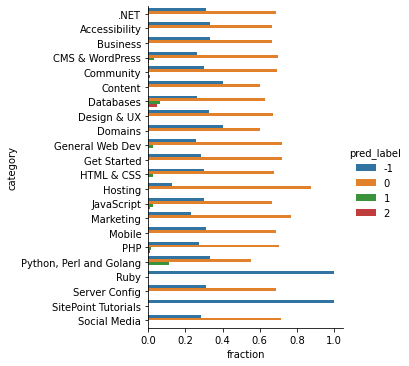

In [30]:
df_plot = df.groupby('category')['pred_label'].value_counts(normalize=True)
df_plot = df_plot.rename('fraction').reset_index()

sns.catplot(
    x='fraction', y='category', hue='pred_label', kind='bar', data=df_plot)